# DATA620: Project 1

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

### Data

For this project, we will be working with a high school contact and friendship network dataset obtained from a previously completed research project on comparison between data collected using wearable sensors, contact diaries, and friendship surveys. We obtained the data from http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/. The dataset contains information from 327 individuals who took part in the study and includes five datasets broken into the following:

* Dynamical contact list
* Directed, weighted contact network from contact diaries
* Directed unweighted friendship network from surveys
* List of pairs of students for which the existence of Facebook link is known
* Metadata
Our two primary data sources are the 'Dynamical contact list' and the 'Metadata' datasets. We are provided with nodes of students who were given an anonymous ID for privacy, the classes where each student socialized, the time of each student interaction, and the gender of the student. The edges in the graph represent social contact between students with the weighted distance reflecting social proximity.

### Hypothetical Outcome

We would like discover if one gender is, substantially, making more interpersonal connections than another. Theoretically, we should see that males and females are as equally as likely to connect to another individual. We may find that this in that the case in our dataset.

### Loading the data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
#plt.rcParams.update({'axes.facecolor':'orange'})

In [2]:
#warnings.filterwarnings("ignore")

In [3]:
# Import data
school_data = pd.read_csv('https://raw.githubusercontent.com/SaneSky109/DATA620/main/Data/High-School_data_2013.csv',
                          sep = ' ',
                         header = None,
                         names = ["Time_sec", "StudentID1", "StudentID2", "Class1", "Class2"])


In [4]:
attribute_data = pd.read_csv('http://www.sociopatterns.org/wp-content/uploads/2015/09/metadata_2013.txt',
                   sep = '\t',
                   header = None,
                   names = ["studentID", "Class", "Gender"])
attribute_data.head(5)

,studentID,Class,Gender
0,650,2BIO1,F
1,498,2BIO1,F
2,627,2BIO1,F
3,857,2BIO1,F
4,487,2BIO1,F


### Transforming the Data

In [5]:
# Create Weights. Students can contact eachother multiple times in a class. Weights can capture how often the students communicate.
weighted_data = school_data.groupby(['StudentID1', 'StudentID2']).size().reset_index(name="Contacts")

# Create weights using 1/contacts to have people who are more social with eachother closer than people who hardly socialize with eachother
weighted_data["weight"] = 1 / weighted_data["Contacts"]

weighted_data.head(5)

,StudentID1,StudentID2,Contacts,weight
0,1,55,8,0.125000
1,1,63,2,0.500000
2,1,101,1,1.000000
3,1,106,4,0.250000
4,1,117,18,0.055556


In [6]:
zip_iter = zip(attribute_data['studentID'].tolist(), attribute_data['Gender'].tolist())
a_dict = dict(zip_iter)

### NetworkX Graph Object

In [7]:
g = nx.from_pandas_edgelist(weighted_data, 
                            source='StudentID1', 
                            target='StudentID2', 
                            create_using = nx.DiGraph(),
                            edge_attr = ["Contacts", "weight"]
                           ) 

In [8]:
for key,n in g.nodes.items():
    n["Gender"]=a_dict[key]

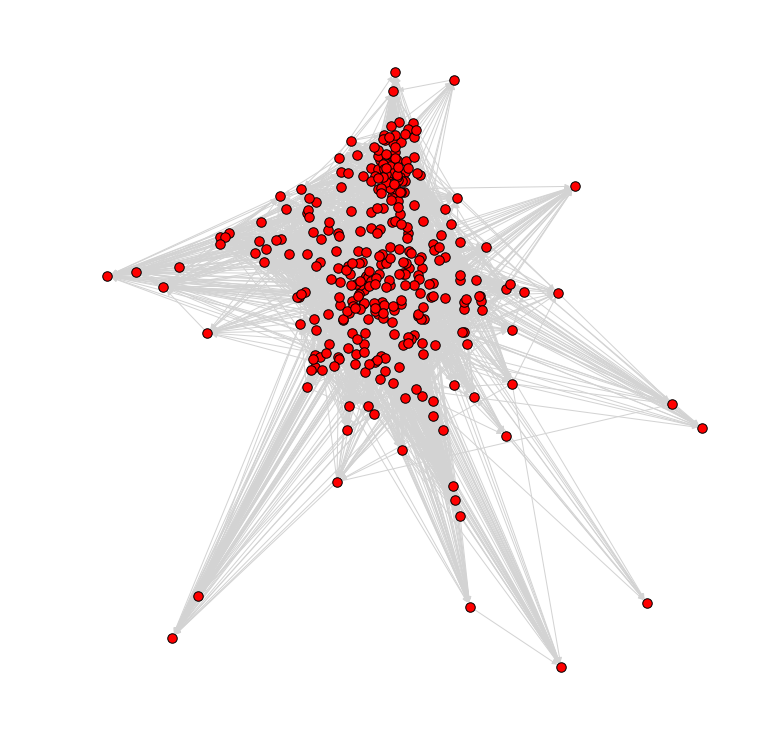

In [71]:
plt.figure(figsize = (10,10))
nx.draw(g, with_labels = False, node_size = 90, font_color = 'black', edgecolors='black',
         font_weight = 'bold', node_color='red', edge_color='lightgray', arrowsbool=True )

### Sub Graph

In [10]:
w = 0.005
sub_g = nx.subgraph(g,
                    ((source) for source, target, attr in g.edges(data=True) 
                    if attr['weight'] < w))

In [11]:
print('Filtering the student graph by all edges with a weight that is less than ' 
      + str(w) + ' generates as sub graph with ' + str(len(sub_g)) + ' nodes')

Filtering the student graph by all edges with a weight that is less than 0.005 generates as sub graph with 137 nodes


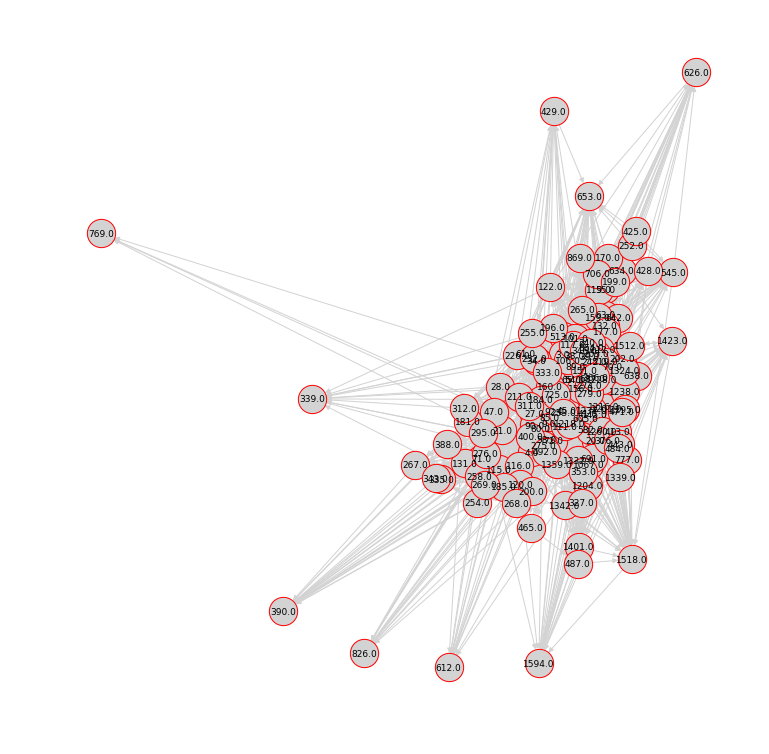

In [12]:
plt.figure(figsize = (10,10))
nx.draw(sub_g, with_labels = True, node_size = 800, font_color = 'black', font_size=9,
        edge_color='lightgray', edgecolors='red', node_color='lightgray', arrowsbool=True)

### Degree Centrality

In [13]:
deg=nx.degree(g)
deg_s = dict(sorted(dict(deg).items(), key=lambda item: item[1],reverse=True)[:10])
deg_s

{106.0: 87,
 1518.0: 84,
 1332.0: 77,
 272.0: 76,
 605.0: 72,
 1359.0: 69,
 9.0: 69,
 232.0: 68,
 376.0: 67,
 275.0: 67}

Degree centrality measures the number of connections an individual node has. The first line in the output above shows us a student with the highest number of contacts. This is the top user in the dataset. 

### Closeness Centrality 

In [14]:
c=nx.closeness_centrality(g)
cs = dict(sorted(c.items(), key=lambda item: item[1],reverse=True)[:10])
cs

{1518.0: 0.49436659873499256,
 1423.0: 0.46783757720007385,
 1512.0: 0.454302343872896,
 1894.0: 0.4542853218569728,
 1359.0: 0.44787348698391644,
 1594.0: 0.4468429087529987,
 1805.0: 0.44647332784677535,
 1332.0: 0.4384028361284084,
 1819.0: 0.4316036252908047,
 1828.0: 0.4271834434819243}

Students with high closeness centrality have a high ability to move information from one side of the network to another. The top ten list indicates nodes that are more central. These students are closer to most of the other student nodes in the graph.

### Boundary Spanners

In [15]:
b=nx.betweenness_centrality(g)
bs = dict(sorted(b.items(), key=lambda item: item[1],reverse=True)[:10])
bs

{605.0: 0.014865800569258862,
 674.0: 0.014845753896991328,
 272.0: 0.011763082788901497,
 245.0: 0.010455203874467361,
 376.0: 0.00907112727440966,
 372.0: 0.00871512803596813,
 424.0: 0.007556434230106044,
 275.0: 0.007419530814581692,
 1332.0: 0.007137200130949082,
 407.0: 0.006962806277102555}

Betweenness centrality shows us students that act as bridges between communities that otherwise would not be able to communicate with each other. 

### Eigenvector Centrality

In [16]:
e = nx.eigenvector_centrality(g, max_iter=1000) 
es = dict(sorted(e.items(), key=lambda item: item[1],reverse=True)[:10])
es

{1894.0: 0.995934181862536,
 1828.0: 0.07326103247116662,
 1819.0: 0.03799368416357973,
 1870.0: 0.03531691982142628,
 1784.0: 0.005347315286971633,
 1805.0: 0.005304012227396992,
 1594.0: 0.00039260541323285557,
 1543.0: 0.00034853951983630007,
 1519.0: 0.0003422296364468425,
 1518.0: 5.0485733719803415e-05}

Degree centrality awards one centrality point for every link a node receives. Not all student connections are equivalent: some are more important than others, and, reasonably, connections with "popular" students count more. It looks like a student with ID # 1894 is extremely influential but does not necessarily have a lot of connections. 

### page rank centrality

In [17]:
pr=nx.pagerank(g) 
prs = dict(sorted(pr.items(), key=lambda item: item[1],reverse=True)[:10])
prs

{1894.0: 0.093215000104072687,
 1828.0: 0.037971295334678579,
 1784.0: 0.021680839767477134,
 1819.0: 0.019965346849316612,
 991.0: 0.017845819785267301,
 1518.0: 0.017475816125924009,
 1805.0: 0.016464633081219201,
 1332.0: 0.016027894185480233,
 1870.0: 0.01468995647286038,
 1423.0: 0.013718543012471092}

We can see a lot of familiar student IDs in all the top ten lists. Every network has a group of popular users that will be more noticeable than others across all centrality metrics.  

### Centrality Measures Summary Table

In [18]:
df = attribute_data.copy()
df.head()

,studentID,Class,Gender
0,650,2BIO1,F
1,498,2BIO1,F
2,627,2BIO1,F
3,857,2BIO1,F
4,487,2BIO1,F


In [19]:
df['Degree'] = df['studentID'].map(dict(deg))
df['Closeness'] = df['studentID'].map(dict(c))
df['Betweenness'] = df['studentID'].map(dict(b))
df['Eigenvector'] = df['studentID'].map(dict(e))
df['PageRank'] = df['studentID'].map(dict(pr))
df.head().round(decimals=4)

,studentID,Class,Gender,Degree,Closeness,Betweenness,Eigenvector,PageRank
0,650,2BIO1,F,39.0,0.2048,0.0013,0.0,0.0026
1,498,2BIO1,F,44.0,0.2035,0.0029,0.0,0.0029
2,627,2BIO1,F,22.0,0.1862,0.0005,0.0,0.0018
3,857,2BIO1,F,24.0,0.2412,0.0015,0.0,0.0028
4,487,2BIO1,F,40.0,0.1656,0.0014,0.0,0.0013


### Centrality measures comparison 

#### Degree

In [20]:
df.groupby("Gender")["Degree"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,36.4828,14.1545,2.0,29.0,36.0,43.0,87.0
M,175.0,34.8857,13.0441,8.0,25.5,35.0,42.0,84.0
Unknown,7.0,34.4286,12.2863,18.0,27.0,35.0,41.0,52.0


The degree centrality on average was higher for Female students. This means that female students have a higher number of connections compared to male students. 

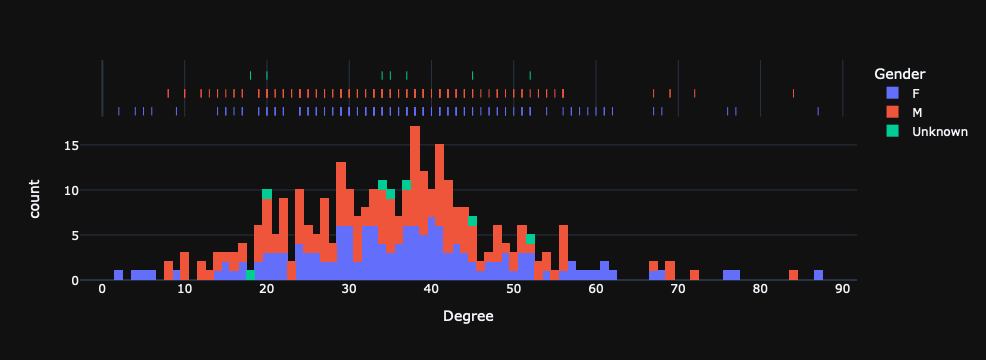

In [41]:
fig = px.histogram(df, x="Degree", color="Gender", marginal="rug",nbins=100, hover_data=df.columns, template = 'plotly_dark')
fig.show()

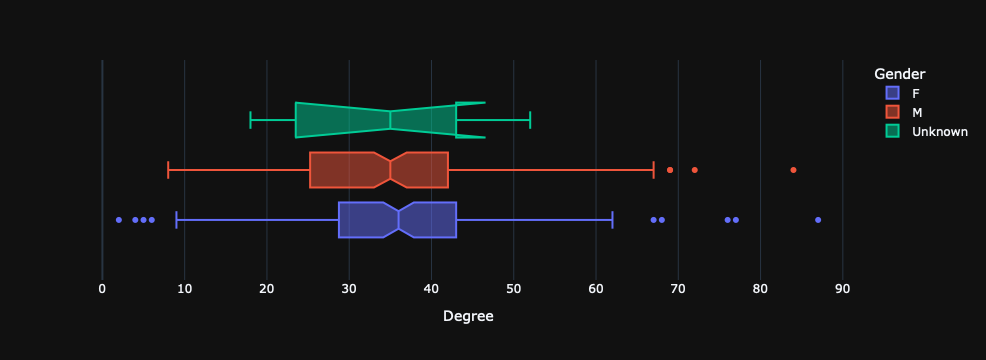

In [42]:
fig = px.box(df, x="Degree", color="Gender", notched=True, template = 'plotly_dark')
fig.show()

#### Closeness

In [23]:
df.groupby("Gender")["Closeness"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.1574,0.1074,0.0,0.0652,0.1453,0.2412,0.4543
M,175.0,0.1824,0.1226,0.0,0.0899,0.1776,0.2676,0.4944
Unknown,7.0,0.0769,0.0900,0.0,0.0123,0.0595,0.1009,0.2525


Interestingly the highest closeness centrality was for male students, meaning that they have a higher ability to move information from one side of the network to another. 

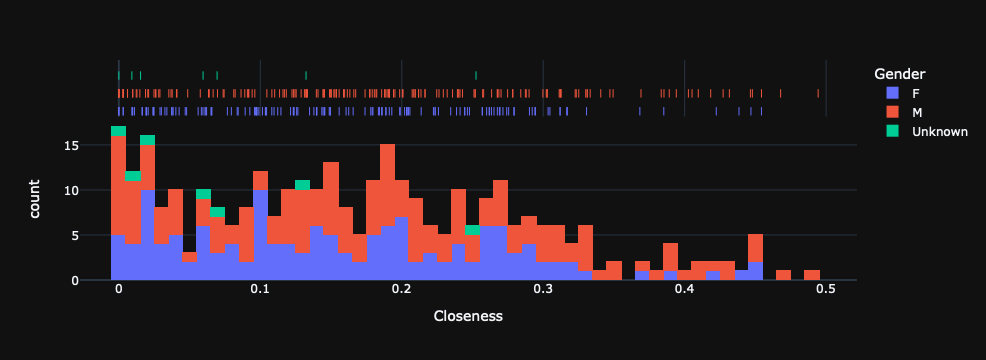

In [43]:
fig = px.histogram(df, x="Closeness", color="Gender", marginal="rug",nbins=80, hover_data=df.columns, template = 'plotly_dark')
fig.show()

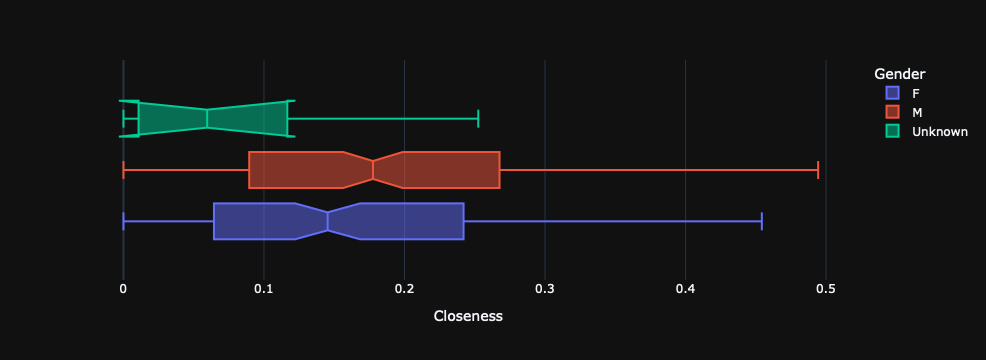

In [44]:
fig = px.box(df, x="Closeness", color="Gender", notched=True, template = 'plotly_dark')
fig.show()

#### Betweenness

In [26]:
df.groupby("Gender")["Betweenness"].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.001934,0.002294,0.0,0.000410,0.001133,0.002688,0.014846
M,175.0,0.001529,0.002007,0.0,0.000177,0.000808,0.002018,0.014866
Unknown,7.0,0.000903,0.000838,0.0,0.000339,0.000634,0.001456,0.002096


Female students tend to act as communication bridges across communities that otherwise would not be able to communicate with each other.

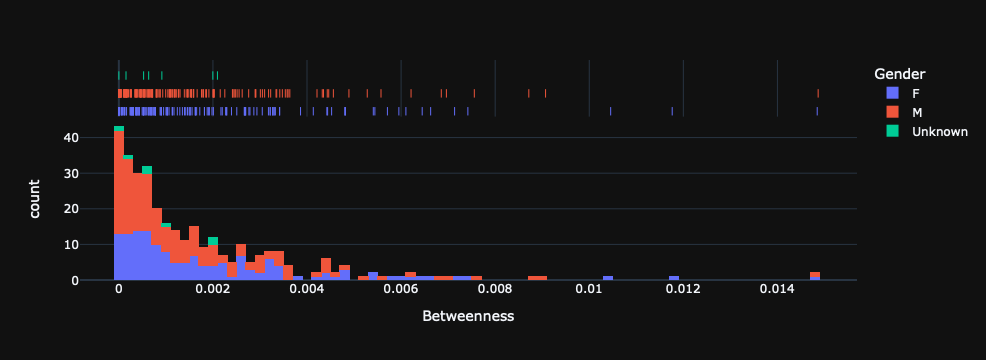

In [45]:
fig = px.histogram(df, x="Betweenness", color="Gender", marginal="rug",nbins=80, hover_data=df.columns, template = 'plotly_dark')
fig.show()

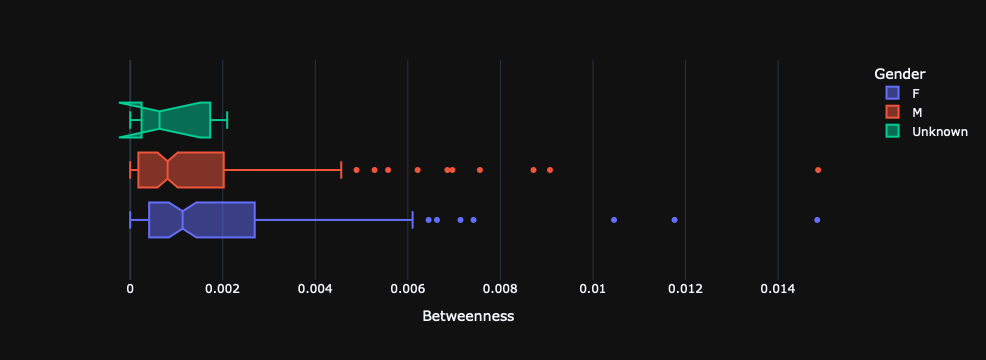

In [46]:
fig = px.box(df, x="Betweenness", color="Gender", notched=True, template = 'plotly_dark')
fig.show()

#### Eigenvector

In [29]:
df.groupby("Gender")["Eigenvector"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.0069,0.0827,0.0,0.0,0.0,0.0,0.9959
M,175.0,0.0009,0.0068,0.0,0.0,0.0,0.0,0.0733
Unknown,7.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000


Female students have higher eigenvector centrality. They can be largely invisible in the network and have a lower number of connections but still have more communication power by knowing well-connected students.

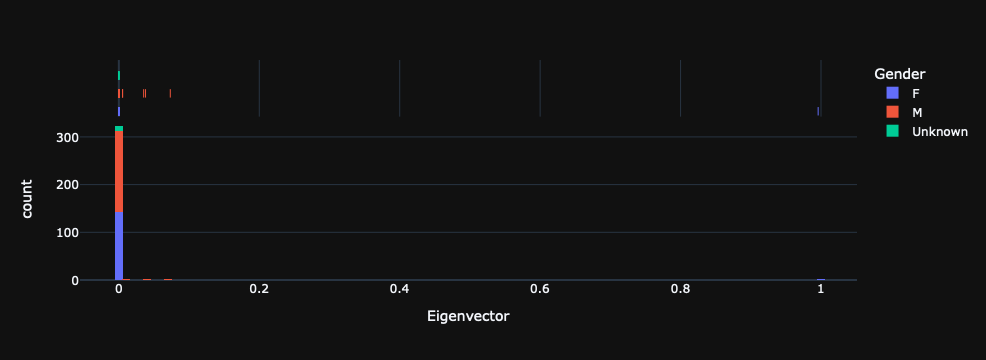

In [47]:
fig = px.histogram(df, x="Eigenvector", color="Gender", marginal="rug",nbins=100, hover_data=df.columns, template = 'plotly_dark')
fig.show()

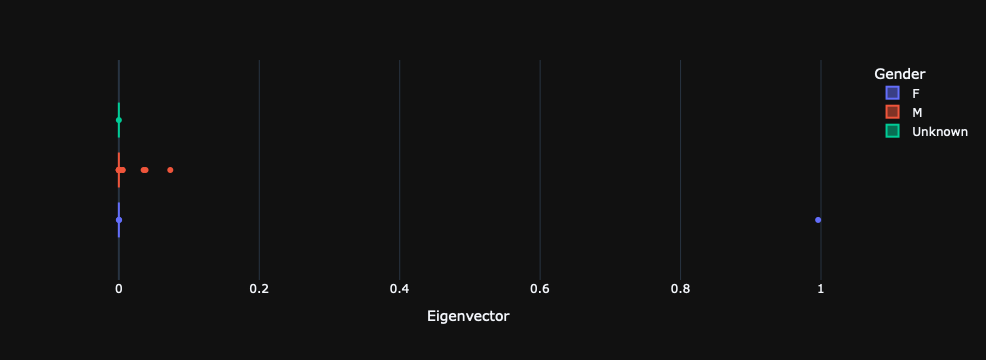

In [48]:
fig = px.box(df, x="Eigenvector", color="Gender", notched=True, template = 'plotly_dark')
fig.show()

#### PageRank

In [32]:
df.groupby("Gender")["PageRank"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.0030,0.0079,0.0009,0.0011,0.0015,0.0028,0.0932
M,175.0,0.0032,0.0046,0.0009,0.0011,0.0016,0.0027,0.0380
Unknown,7.0,0.0013,0.0009,0.0009,0.0009,0.0010,0.0011,0.0032


PageRank measures the importance of each node within the group, based on the number incoming relationships and the importance of the corresponding source nodes. Only immediate neighbors are taken into consideration. This measure looks similar for both genders.

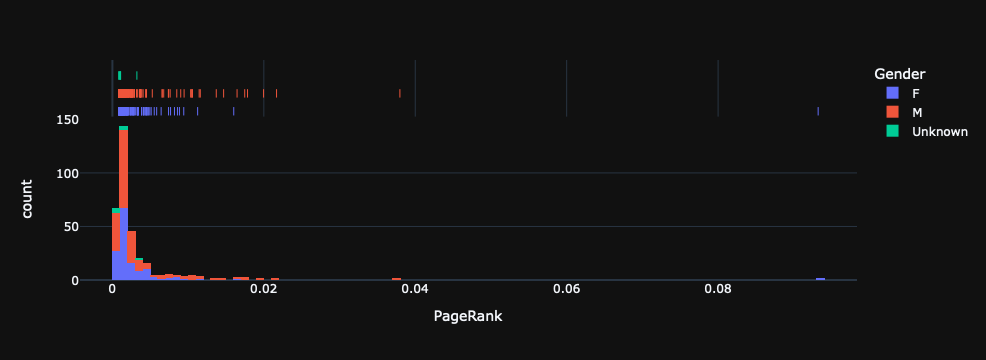

In [70]:
fig = px.histogram(df, x="PageRank", color="Gender", marginal="rug",nbins=100, hover_data=df.columns, template = 'plotly_dark')
fig.show()

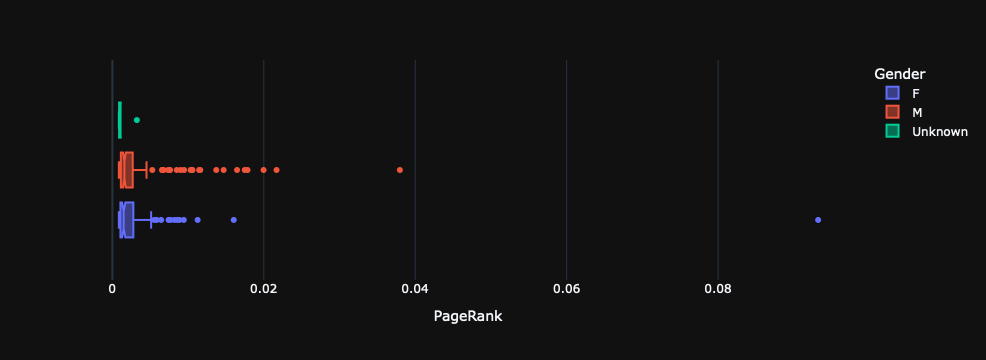

In [69]:
fig = px.box(df, x="PageRank", color="Gender", notched=True, template = 'plotly_dark')
fig.show()

### 3D Exploration

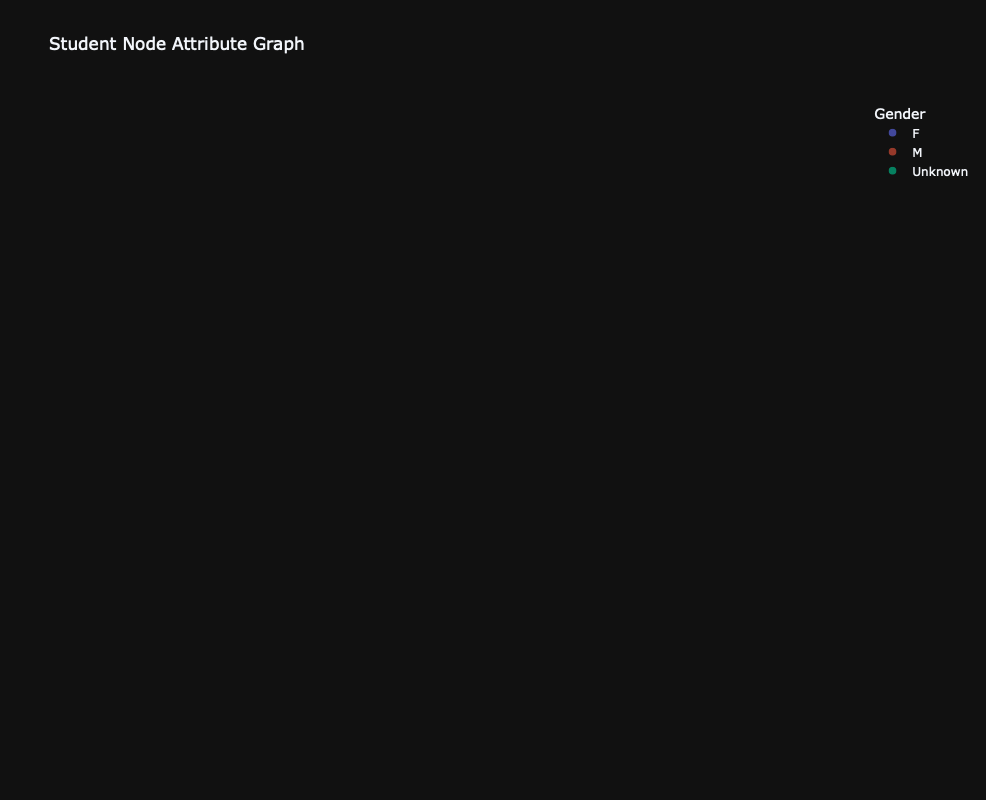

In [68]:
fig = px.scatter_3d(df, x="Degree", y="Betweenness", z="PageRank", color="Gender", 
                    hover_name="studentID", width=1100, height=800, opacity=0.6, 
                   title="Student Node Attribute Graph", template = 'plotly_dark')
fig.show()

### T-Test

### Conclusion